In [139]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

import sys
sys.path.append("../") # go to parent dir
from samplers import memory_mnist, memory_fashion
from utils import expspace


In [140]:
def calculate_coeff(data, min_i, max_i, log=False, plot=False, show=False):
    data = np.array(data)
    data_clean = data[np.all(~np.isnan(data), axis=1)]
    ind_sort = np.argsort(data_clean[:,0])
    data_clean = data_clean[ind_sort]
    d, ll = tuple(zip(*data_clean))

    d = d[min_i:max_i]
    ll = ll[min_i:max_i]

    d = np.array(d).reshape(-1,1)
    ll = np.array(ll)
#     print(d)
    
    if log:
        d = np.log(d)
#     regr = linear_model.TheilSenRegressor()
    regr = linear_model.LinearRegression()
    regr.fit(d, ll)
    ll_pred = regr.predict(d)

    if plot:
        plt.plot(d, regr.predict(d), label="prediction", c='r', alpha=0.5)
        plt.plot(d, ll, 'o-', alpha=0.5)
    if show:
        plt.show()
        
    return regr.coef_[0]


In [141]:
image_size = 32
n_channels = 1
n_pixel = image_size * image_size * n_channels
val_flag = True

n = 80
cls = 0
directory = "DATA_DIR"


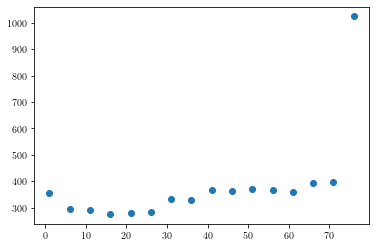

In [142]:
dims = []
ns = list(range(1, n, 5))
for n in ns:
    fnames = sorted(glob.glob(f"{directory}/ll_*_{n}.txt"), key=lambda a: float(a.split("_")[-2].split("#")[-1]))
#     print(fnames)
    to_plot = []
    for f in fnames:
#         print(n)
        txt = pd.read_csv(f, sep=" ", header=None)
        if val_flag:
            txt = txt
        if val_flag:
            noise, pz, logdet, _, _ = txt.mean()
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    dim = n_pixel - calculate_coeff(to_plot, 0, 16, log=True, plot=False)
#     print(coef)
    dims.append(dim)
plt.scatter(ns, dims)

In [143]:
train_loader, val_loader, train_val_loader, train_labels, val_labels, train_val_labels = memory_fashion(
    1, 32, 1, return_y=True
)

In [146]:
import glob

# minimum_delta = 1/256*np.random.random(1000).std()*10
# maximum_delta = 1.0

minimum_delta = 0
maximum_delta = 10000


fnames = []

for filename in sorted(glob.glob(f"{directory}/*train*"), key=lambda a: float(a.split("_")[-2].split("#")[-1])):
    test_filename = filename.replace("train", "test")
    data = pd.read_csv(filename, header=None)
    delta = filename.split("#")[-1].split("_")[0]
    is_na = np.any(pd.isna(data.iloc[:,0]))
    data = pd.read_csv(test_filename, header=None)
    is_na_test = np.any(pd.isna(data.iloc[:,0]))
    if is_na or is_na_test or float(delta) < minimum_delta or maximum_delta < float(delta):
        continue
    else:
        n = data.iloc[:,0].argmin()
        print(n, delta)
        fnames.append(glob.glob(f"{directory}/ll_*{delta}_{n}.txt")[0])

len(fnames)
# print(fnames)

64 0.00144974067
46 0.00226380341
48 0.00353498111
38 0.00551995432
34 0.00861953566
42 0.0134596032
37 0.0210174801
40 0.0328192787
53 0.0512480588
27 0.0800250228
43 0.124960914
21 0.195129342
20 0.304698957
10 0.475794431
10 0.742963951
3 1.1601553


16

In [159]:
window = 2

coeff_list_cls = []
for cls in range(10):
    to_plot = []
    noises = []
    for f in fnames:
#         print(f)
        txt = pd.read_csv(f, sep=" ", header=None)
        if val_flag:
            txt = txt[val_labels.numpy() == cls]
        else:
            txt = txt[train_labels[-5000:].numpy() == cls]
        if val_flag:
            noise, pz, logdet, _, _ = txt.mean()
        else:
            noise, _, _, pz, logdet = txt.mean()
        to_plot.append([noise, -(pz + logdet)])
        noises.append(noise)
    to_plot = np.array(to_plot) + 1e-6
    coef_list = [calculate_coeff(to_plot, i, i+window+1, log=True, plot=False) for i in range(len(to_plot)-window)]
    coeff_list_cls.append(n_pixel - np.array(coef_list))

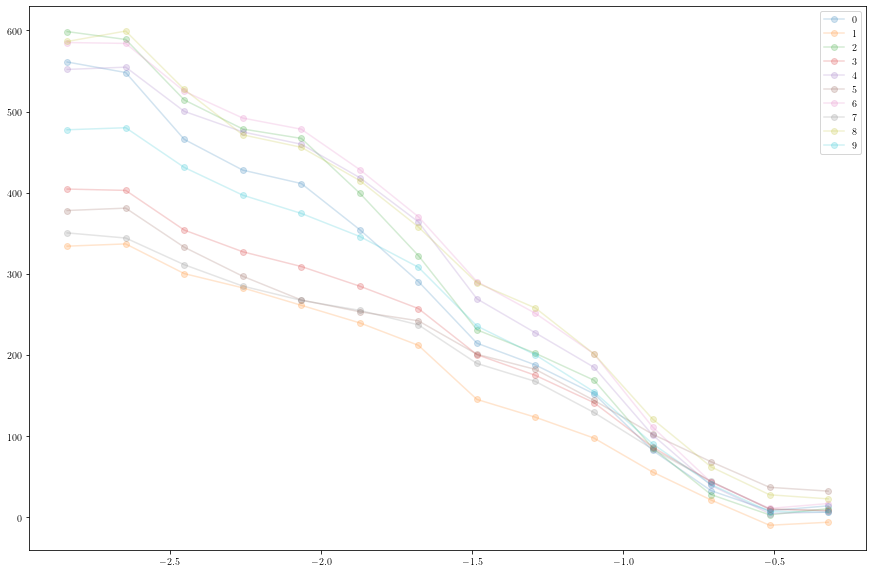

In [160]:
coeff_list_cls
plt.figure(figsize=(15,10))
dims = np.array(coeff_list_cls)
for i in range(10):
    plt.plot(np.log10(noises)[:-window], dims[i], 'o-', label=str(i), alpha=0.2)
plt.legend()

In [171]:
n = 5

txt_list = []
for f in fnames:
    txt = pd.read_csv(f, sep=" ", header=None)
    txt_list.append(txt)


val_flag = True

dims_l = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    to_plot = []
    for txt in txt_list:
        if val_flag:
            noise, pz, logdet, _, _ = txt.iloc[i]
        else:
            noise, _, _, pz, logdet = txt.iloc[i]
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = calculate_coeff(to_plot, 0, n, log=True, plot=False)
    dims_l.append(n_pixel - coef)


0
1000
2000
3000
4000


In [172]:
txt_list = []
for f in fnames:
    txt = pd.read_csv(f, sep=" ", header=None)
    txt_list.append(txt)
    
dims_h = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    to_plot = []
    for txt in txt_list:
        if val_flag:
            noise, pz, logdet, _, _ = txt.iloc[i]
        else:
            noise, _, _, pz, logdet = txt.iloc[i]
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = calculate_coeff(to_plot, n, 2*n, log=True, plot=False)
    dims_h.append(n_pixel - coef)

0
1000
2000
3000
4000


In [194]:
txt_list = []
for f in fnames:
    txt = pd.read_csv(f, sep=" ", header=None)
    txt_list.append(txt)
    
dims = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    to_plot = []
    for txt in txt_list:
        if val_flag:
            noise, pz, logdet, _, _ = txt.iloc[i]
        else:
            noise, _, _, pz, logdet = txt.iloc[i]
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = calculate_coeff(to_plot, n,2*n, log=True, plot=False)
    dims.append(n_pixel - coef)

0
1000
2000
3000
4000


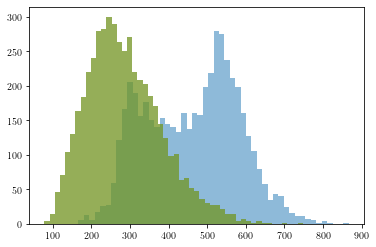

In [195]:
plt.hist(dims_l, bins=50, alpha=0.5);
plt.hist(dims_h, bins=50, alpha=0.5);
plt.hist(dims, bins=50, alpha=0.5);


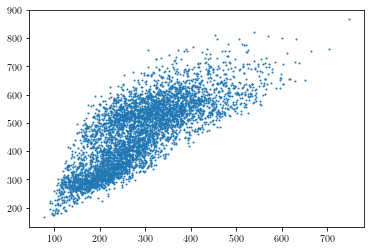

In [196]:
plt.scatter(dims_h, dims_l, s=1)

In [197]:

temp = np.argsort(dims_l)
r_l = np.empty_like(temp)
r_l[temp] = np.arange(len(dims_l))
temp = np.argsort(dims_h)
r_h = np.empty_like(temp)
r_h[temp] = np.arange(len(dims_h))

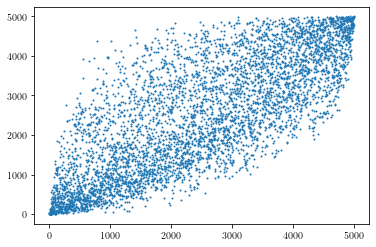

In [198]:
plt.scatter(r_h, r_l, s=1)

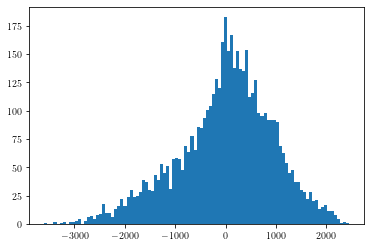

In [199]:
plt.hist(r_h - r_l, bins=100);

In [200]:
np.abs(r_h - r_l).mean() / len(r_h)

0.14711887999999998

In [201]:
acc = []
for _ in range(10000):
    i1 = np.random.randint(5000)
    i2 = np.random.randint(5000)
    acc.append((dims_h[i1] < dims_h[i2]) == (dims_l[i1] < dims_l[i2]))

np.mean(acc)

0.7952

<Figure size 1440x72 with 0 Axes>

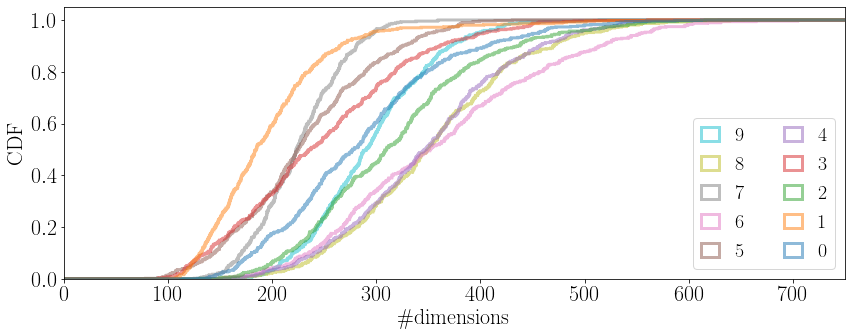

In [202]:
plt.figure(figsize=(20,1))
dims = np.array(dims)
datasets = []
for cls in range(10):
    if val_flag:
        datasets.append(dims[val_labels.numpy() == cls])
    else:
        datasets.append(dims[train_labels[50000:].numpy() == cls])
        
import matplotlib
matplotlib.rc('text', usetex=True)
plt.rcParams['font.family'] = 'serif'
label_size = 22
ticks_size = 22
legend_size = 20
fig, ax = plt.subplots(1, 1, figsize=(14,5))
ax.tick_params(labelsize=ticks_size)
# ax.set_xticks(range(0,4,1))
# ax.set_yticks(range(0,4,1))
# plt.xlim(-0.1,3.1)
# plt.ylim(-0.1,3.1)
        
ax.hist(datasets, bins=np.linspace(0, 32*32, 10000), label=list(map(str, list(range(10)))), stacked=False,
        histtype="step", cumulative=True, alpha=0.5, density=True, linewidth=3);

plt.xlim(0, 750)
plt.legend(loc="lower right", ncol=2, fontsize=legend_size, handlelength=0.9)
ax.set_xlabel("\#dimensions", size=label_size)
ax.set_ylabel("CDF", size=label_size);

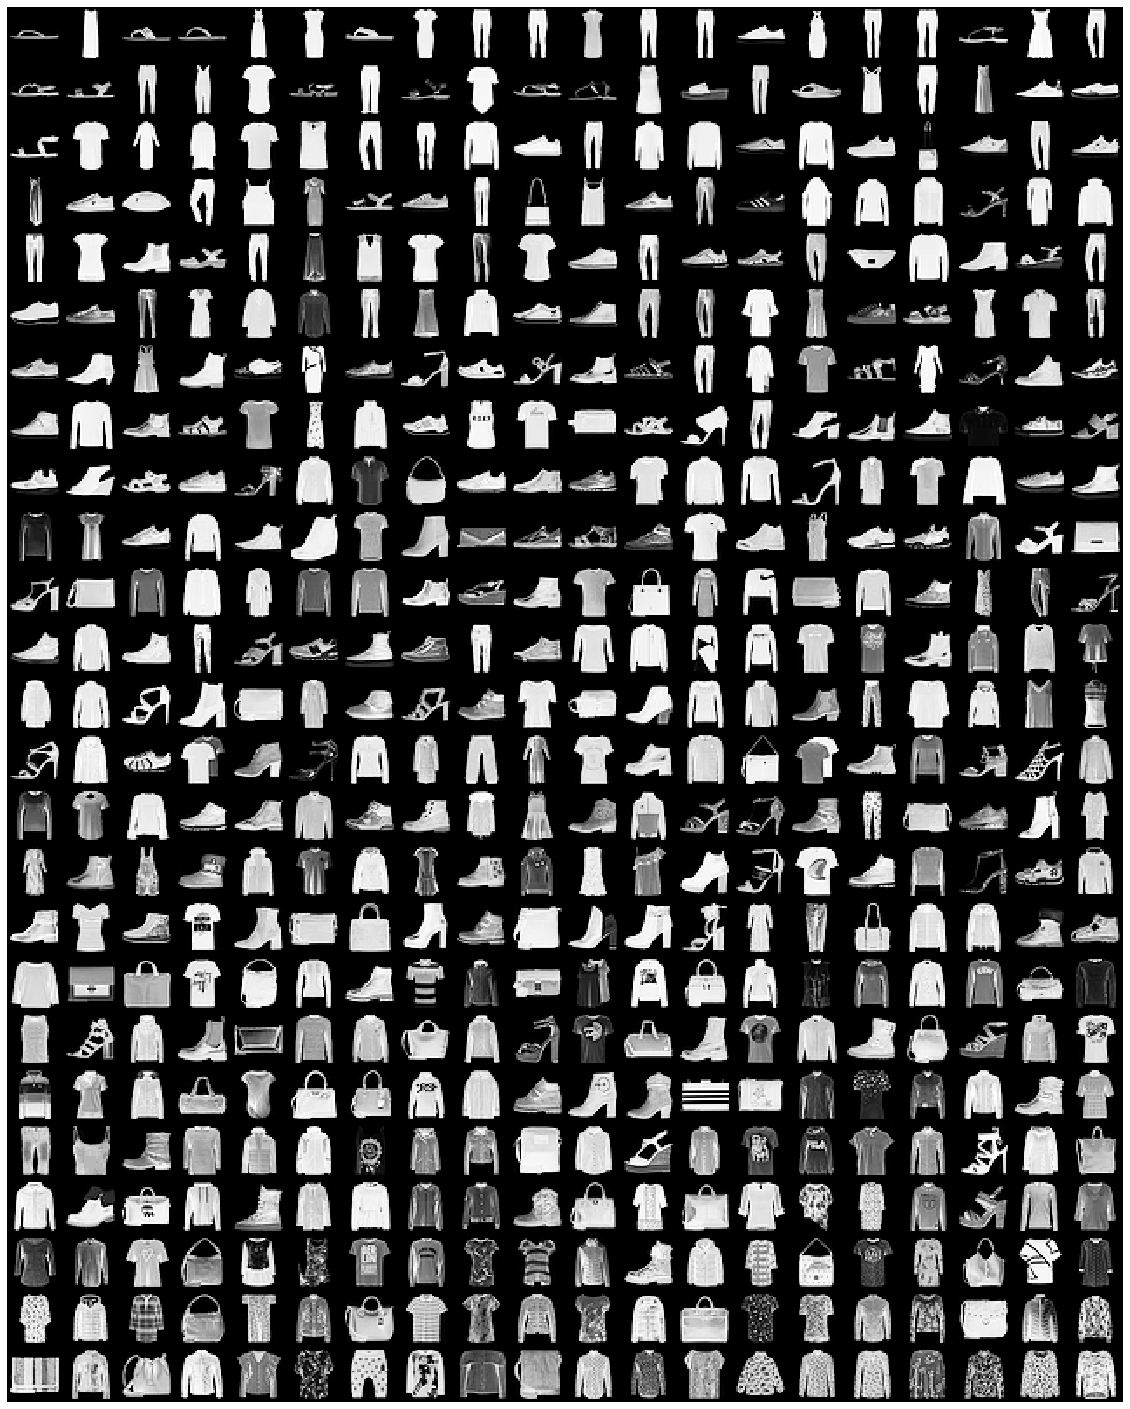

In [203]:
plt.figure(figsize=(20, 40))
m = 200
skip = 10
img_list = []
for i in range(0, 5000, m):
    imgs = []
    for j in range(0, m, skip):
        ind = dims.argsort()[i + j]
        if val_flag:
            imgs.append(val_loader.dataset[ind][0])
        else:
            imgs.append(train_val_loader.dataset[ind][0])
    imgs = np.concatenate(imgs, axis=1)
    img_list.append(imgs)
plt.matshow(-np.concatenate(img_list, axis=0), fignum=1, cmap="Greys")
plt.axis('off')
plt.show()

In [205]:
import torch
dims = np.array(dims)

m = 5
imgs = []
tmp = []
for i in dims.argsort()[:m]:
    tmp.append(val_loader.dataset[i][0])
imgs.append(np.concatenate(tmp, axis=1))
tmp = []
for i in dims.argsort()[2500:(2500+m)]:
    tmp.append(val_loader.dataset[i][0])
imgs.append(np.concatenate(tmp, axis=1))
tmp = []
for i in dims.argsort()[-m:]:
    tmp.append(val_loader.dataset[i][0])
imgs.append(np.concatenate(tmp, axis=1))

    
plt.imshow(-np.concatenate(imgs, axis=0)+0.5, cmap="Greys")

In [95]:
from scipy.stats import pearsonr

In [97]:
from torch.utils.data import DataLoader

In [98]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = x.view(x.shape[0], 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [123]:
n_train = 50000

train_dim_data = train_loader.dataset.tensors[-n_train:].reshape(-1,1,28,28) / 255.
train_dim_labels = train_labels[-n_train:]
# train_dim_data = train_loader.dataset.tensors[-5000:].reshape(5000,1,28,28) / 255.
# train_dim_labels = train_labels[-5000:]
val_dim_data = val_loader.dataset.tensors[:].reshape(-1,1,28,28) / 255.
val_dim_labels = val_labels
order = np.argsort(dims)

# for label in range(10):
    

# train_easy = train_dim_data[order][:n_train]
# labels_easy = train_dim_labels[order][:n_train]
# train_hard = train_dim_data[order][-n_train:]
# labels_hard = train_dim_labels[order][-n_train:]


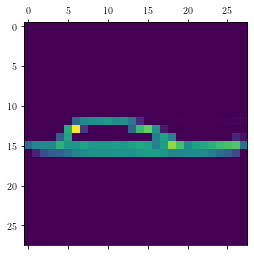

In [124]:
plt.matshow(val_dim_data[np.argmin(dims)][0])

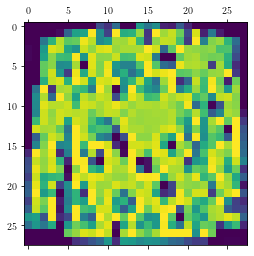

In [125]:
plt.matshow(val_dim_data[np.argmax(dims)][0])

In [126]:
bs = 32
# dl = DataLoader(list(zip(train_easy, labels_easy)), batch_size=bs, shuffle=True)
# dl = DataLoader(list(zip(train_hard, labels_hard)), batch_size=bs, shuffle=True)

vl = DataLoader(list(zip(val_dim_data, val_dim_labels)), batch_size=1)

dl = DataLoader(list(zip(train_dim_data, train_dim_labels)), batch_size=bs, shuffle=True)

In [127]:
import torch
import torch.optim as optim

device = 'cuda'

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters())

for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(dl, 0):
        inputs, labels = data
        
#         inputs = inputs.reshape(inputs.shape[0], 1, 32, 32)

        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    outputs = []
    for inputs, labels in vl:
        outputs.append(net(inputs.to(device)).argmax().item())
    preds = torch.tensor(outputs)
    acc = (preds == val_labels).float().numpy().mean()
    print('[%d, %5d] loss: %.4f, acc: %.2f' %
          (epoch + 1, i + 1, running_loss / 2000, acc))
    running_loss = 0.0

print('Finished Training')

[1,  1563] loss: 0.4979, acc: 0.81
[2,  1563] loss: 0.3325, acc: 0.84
[3,  1563] loss: 0.2832, acc: 0.86
[4,  1563] loss: 0.2579, acc: 0.88
[5,  1563] loss: 0.2371, acc: 0.88
[6,  1563] loss: 0.2228, acc: 0.89
[7,  1563] loss: 0.2096, acc: 0.88
[8,  1563] loss: 0.1995, acc: 0.89
[9,  1563] loss: 0.1893, acc: 0.90
[10,  1563] loss: 0.1819, acc: 0.90
[11,  1563] loss: 0.1745, acc: 0.90
[12,  1563] loss: 0.1662, acc: 0.90
[13,  1563] loss: 0.1629, acc: 0.89
[14,  1563] loss: 0.1553, acc: 0.90
[15,  1563] loss: 0.1488, acc: 0.90
[16,  1563] loss: 0.1449, acc: 0.89
[17,  1563] loss: 0.1391, acc: 0.90
[18,  1563] loss: 0.1340, acc: 0.89
[19,  1563] loss: 0.1293, acc: 0.90
[20,  1563] loss: 0.1257, acc: 0.90
[21,  1563] loss: 0.1225, acc: 0.89
[22,  1563] loss: 0.1177, acc: 0.90
[23,  1563] loss: 0.1145, acc: 0.90
[24,  1563] loss: 0.1106, acc: 0.90
[25,  1563] loss: 0.1072, acc: 0.90
[26,  1563] loss: 0.1020, acc: 0.90
[27,  1563] loss: 0.1022, acc: 0.89
[28,  1563] loss: 0.0975, acc: 0.89
[

In [128]:
outputs = []
for inputs, labels in vl:
    outputs.append(net(inputs.to(device)))

In [129]:
outputs = torch.cat(outputs)

In [130]:
import torch
preds = torch.tensor([o.argmax().item() for o in outputs])

In [131]:
good = (preds == val_labels).int().numpy()

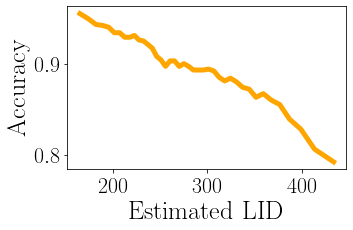

In [204]:
matplotlib.rc('text', usetex=True)
plt.rcParams['font.family'] = 'serif'
label_size = 26
ticks_size = 22
legend_size = 22
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

dims_ = np.array(dims)
good_ = good
step = 100
window = 1000
accs = [good_[np.argsort(dims_)][i:(i + window)].mean() for i in range(0,len(good_)-window+1,step)]
dims_m = [dims_[np.argsort(dims_)][i:(i + window)].mean() for i in range(0,len(good_)-window+1,step)]
plt.plot(dims_m, accs, '-', c='orange',  linewidth=5)

ax.tick_params(labelsize=ticks_size)
ax.set_ylabel("Accuracy", size=label_size)
ax.set_xlabel("Estimated LID", size=label_size)

plt.show()


False
True
True
True
True
True
True
True
True
False


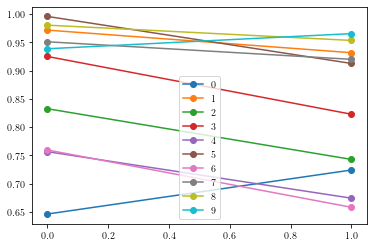

In [122]:
for c in range(10):
    dims_ = np.array(dims)[val_labels == c]
    good_ = good[val_labels == c]
    step = 50
    window = 50
#     accs = [good_[np.argsort(dims_)][i:(i + window)].mean() for i in range(0,len(good_)-window+1,step)]
#     dims_m = [dims_[np.argsort(dims_)][i:(i + window)].mean() for i in range(0,len(good_)-window+1,step)]
#     accs = [good_[np.argsort(dims_)][i:].mean() for i in range(0,len(good_)-window+1,step)]
#     dims_m = [dims_[np.argsort(dims_)][i:].mean() for i in range(0,len(good_)-window+1,step)]
    l = len(good_)
    s = l//2
    lower, upper = good_[np.argsort(dims_)][:s].mean(), good_[np.argsort(dims_)][s:].mean()
    plt.plot([lower, upper], 'o-', label = str(c))
    print(lower >= upper)

plt.legend()
plt.show()
